In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from utils._utils import red_channel_attenuation

img_fp = '/DataA/pwz/workshop/Datasets/new_uw4/trainB/nature_00033.jpg'
img_arr = np.asarray(Image.open(img_fp))
red_att_img = red_channel_attenuation(img_fp)

result = np.concatenate((img_arr, red_att_img), axis=1)

plt.figure(figsize=(10,6))
plt.imshow(result)
plt.axis('off')
plt.show()

In [ ]:
import os
from PIL import Image

from utils._utils import red_channel_attenuation

src_dir = '/DataA/pwz/workshop/Datasets/RCAD/A'
tgt_dir = '/DataA/pwz/workshop/Datasets/RCAD/B'
img_list = os.listdir(src_dir)
for img_name in img_list:
    img_fp = os.path.join(src_dir, img_name)
    res = red_channel_attenuation(img_fp)
    Image.fromarray(res).save(os.path.join(tgt_dir, img_name))

In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

from data import (
    create_train_dataset, create_train_dataloader
)

ds_cfg_fp = 'configs/dataset/rcad.yaml'
ds_cfg = yaml.load(open(ds_cfg_fp, 'r'), yaml.FullLoader)
train_ds = create_train_dataset(ds_cfg['train'])
train_dl_cfg = {
    'batch_size': 4,
    'shuffle': True,
    'num_workers': 4
}
train_dl = create_train_dataloader(train_ds, train_dl_cfg)

val_ds = create_train_dataset(ds_cfg['val'])
val_dl_cfg = {
    'batch_size': 4,
    'shuffle': True,
    'num_workers': 4
}
val_dl = create_train_dataloader(val_ds, val_dl_cfg)

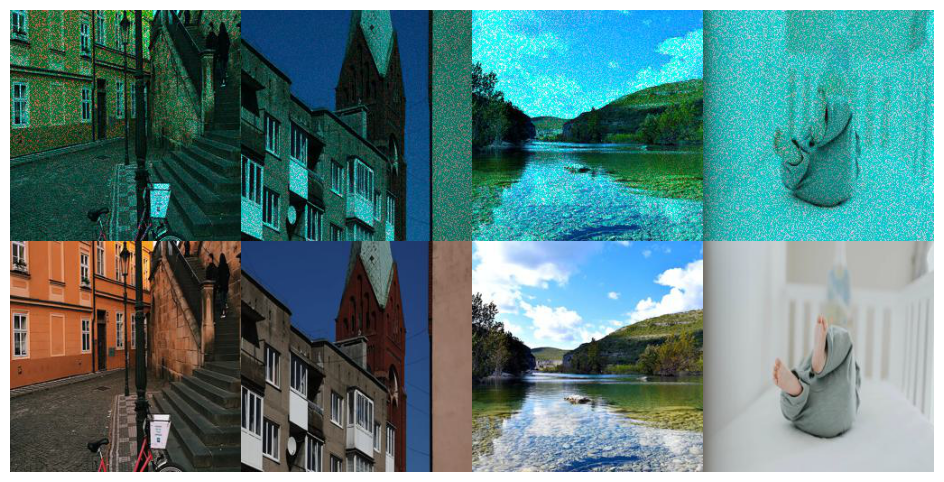

In [2]:
for batch in train_dl:
    inp_imgs = batch['inp']
    ref_imgs = batch['ref']
    paired_imgs = []
    for inp_img, ref_img in zip(inp_imgs, ref_imgs):
        inp_img = inp_img.numpy().transpose(1,2,0)
        ref_img = ref_img.numpy().transpose(1,2,0)
        paired_imgs.append(np.concatenate((inp_img, ref_img), axis=0))
    res_img = np.concatenate(paired_imgs, axis=1)

    plt.figure(figsize=(12,6))
    plt.imshow(res_img)
    plt.axis('off')
    plt.show()

    break

In [14]:
from models.network import FeatureExtractor, ColorCorrection


feat_extractor = FeatureExtractor()
ccm = ColorCorrection(4, 256, 2, 1)
for batch in train_dl:
    inp_imgs = batch['inp']
    feats = feat_extractor(inp_imgs)
    for k,feat in feats.items():
        print(k, feat.shape)
    out = ccm(list(feats.values()))
    print(out.shape)
    break

0 torch.Size([4, 256, 56, 56])
1 torch.Size([4, 256, 28, 28])
2 torch.Size([4, 256, 14, 14])
3 torch.Size([4, 256, 7, 7])
torch.Size([4, 1, 224, 224])


In [ ]:
from models.network import ColorEnhancementNet

net = ColorEnhancementNet()
print(net)
for batch in train_dl:
    inp_imgs = batch['inp']
    out = net(inp_imgs)
    print(out.shape)
    break

In [ ]:
from models.network import RANet

net = RANet(3, 3, 6, 3)
print(net)
for batch in train_dl:
    inp_imgs = batch['inp']
    out = net(inp_imgs)
    print(out.shape)
    break

In [19]:
import matplotlib.pyplot as plt
# plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    fig.set_size_inches(4*len(imgs), 4)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = img.cpu().numpy().transpose(1,2,0)
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    fig.show()

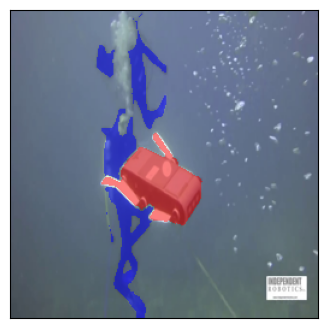

In [26]:
from PIL import Image
import torch
from torchvision.utils import draw_segmentation_masks
import numpy as np
import matplotlib.pyplot as plt

# the re-annotated SUIM
img_fp = '/DataA/pwz/workshop/Datasets/SUIM_fix/train_val/images/d_r_59_.jpg'
mask_fp = '/DataA/pwz/workshop/Datasets/SUIM_fix/train_val/masks/d_r_59_.bmp'

# the original SUIM
# img_fp = '/DataA/pwz/workshop/Datasets/SUIM/train_val/images/d_r_59_.jpg'
# mask_fp = '/DataA/pwz/workshop/Datasets/SUIM/train_val/masks/d_r_59_.bmp'

img_size = (256, 256)
img = Image.open(img_fp).resize(img_size)
img = np.asarray(img, dtype=np.uint8)
mask = Image.open(mask_fp).resize(img_size)
mask = np.asarray(mask, dtype=np.uint8)

mask_shape = mask.shape[0:2]
# Human Diver
hd_mask = np.stack((np.zeros(mask_shape), np.zeros(mask_shape), np.ones(mask_shape)), axis=2)
hd_mask = (hd_mask * 255).astype(np.uint8)
# Robots
ro_mask = np.stack((np.ones(mask_shape), np.zeros(mask_shape), np.zeros(mask_shape)), axis=2)
ro_mask = (ro_mask * 255).astype(np.uint8)
hd_boolean_mask = np.all(mask == hd_mask, axis=2)
ro_boolean_mask = np.all(mask == ro_mask, axis=2)
img = torch.tensor(img.transpose(2,0,1), dtype=torch.uint8)
boolean_masks = torch.tensor(np.stack((hd_boolean_mask, ro_boolean_mask), axis=0), dtype=torch.bool)
imgs_with_masks = [draw_segmentation_masks(img, boolean_masks, alpha=0.5, colors=['blue', 'red'])]
show(imgs_with_masks)

In [17]:
import os
from PIL import Image
import numpy as np
from shutil import copy

image_dir = '/DataA/pwz/workshop/Datasets/SUIM/train_val/images'
masks_dir = '/DataA/pwz/workshop/Datasets/SUIM/train_val/masks'
# need_reannot_dir = '/DataA/pwz/workshop/Datasets/SUIM_new/train_val/need_re_annot'

# image_dir = '/DataA/pwz/workshop/Datasets/SUIM_new/test/images'
# masks_dir = '/DataA/pwz/workshop/Datasets/SUIM_new/test/masks'
# need_reannot_dir = '/DataA/pwz/workshop/Datasets/SUIM_new/test/need_re_annot'

img_names = sorted(os.listdir(image_dir))
mask_names = sorted(os.listdir(masks_dir))
for img_name, mask_name in zip(img_names, mask_names):
    img = Image.open(os.path.join(image_dir, img_name))
    mask = Image.open(os.path.join(masks_dir, mask_name))
    img = np.asarray(img, dtype=np.uint8)
    mask = np.asarray(mask, dtype=np.uint8)
    r = np.all((mask==0)|(mask==255))
    if (not r) or (img.shape != mask.shape):
        # copy(os.path.join(image_dir, img_name), os.path.join(need_reannot_dir, 'images', img_name))
        # copy(os.path.join(masks_dir, mask_name), os.path.join(need_reannot_dir, 'improper_masks', mask_name))
        print(img_name, mask_name)

d_r_112_.jpg d_r_112_.bmp
d_r_135_.jpg d_r_135_.bmp
d_r_174_.jpg d_r_174_.bmp
d_r_179_.jpg d_r_179_.bmp
d_r_189_.jpg d_r_189_.bmp
d_r_20_.jpg d_r_20_.bmp
d_r_270_.jpg d_r_270_.bmp
d_r_273_.jpg d_r_273_.bmp
d_r_293_.jpg d_r_293_.bmp
d_r_301_.jpg d_r_301_.bmp
d_r_310_.jpg d_r_310_.bmp
d_r_333_.jpg d_r_333_.bmp
d_r_470_.jpg d_r_470_.bmp
d_r_473_.jpg d_r_473_.bmp
d_r_564_.jpg d_r_564_.bmp
d_r_59_.jpg d_r_59_.bmp
d_r_5_.jpg d_r_5_.bmp
d_r_633_.jpg d_r_633_.bmp
d_r_65_.jpg d_r_65_.bmp
d_r_741_.jpg d_r_741_.bmp
d_r_759_.jpg d_r_759_.bmp
f_r_1006_.jpg f_r_1006_.bmp
f_r_1007_.jpg f_r_1007_.bmp
f_r_1013_.jpg f_r_1013_.bmp
f_r_1058_.jpg f_r_1058_.bmp
f_r_1068_.jpg f_r_1068_.bmp
f_r_1069_.jpg f_r_1069_.bmp
f_r_1070_.jpg f_r_1070_.bmp
f_r_1133_.jpg f_r_1133_.bmp
f_r_1142_.jpg f_r_1142_.bmp
f_r_1151_.jpg f_r_1151_.bmp
f_r_1154_.jpg f_r_1154_.bmp
f_r_1183_.jpg f_r_1183_.bmp
f_r_1214_.jpg f_r_1214_.bmp
f_r_1233_.jpg f_r_1233_.bmp
f_r_1246_.jpg f_r_1246_.bmp
f_r_1259_.jpg f_r_1259_.bmp
f_r_1267_.jpg f_

In [14]:
from PIL import Image
import numpy as np
from shutil import copy

masks_dir = '/DataA/pwz/workshop/Datasets/SUIM_new/train_val/masks'
mask_names = sorted(os.listdir(masks_dir))
for mask_name in mask_names:
    mask = Image.open(os.path.join(masks_dir, mask_name))
    mask = np.asarray(mask, dtype=np.uint8)
    if mask.shape[-1] == 4:
        new_mask = mask[:, :, 0:-1]
        new_mask = Image.fromarray(new_mask)
        new_mask.save(os.path.join(masks_dir, mask_name))
        print(mask_name)

d_r_112_.bmp
d_r_135_.bmp
d_r_174_.bmp
d_r_179_.bmp
d_r_189_.bmp
d_r_20_.bmp
d_r_270_.bmp
d_r_273_.bmp
d_r_293_.bmp
d_r_301_.bmp
d_r_310_.bmp
d_r_333_.bmp
d_r_470_.bmp
d_r_473_.bmp
d_r_564_.bmp
d_r_59_.bmp
d_r_5_.bmp
d_r_633_.bmp
d_r_65_.bmp
d_r_741_.bmp
d_r_759_.bmp
f_r_1006_.bmp
f_r_1007_.bmp
f_r_1013_.bmp
f_r_1058_.bmp
f_r_1068_.bmp
f_r_1069_.bmp
f_r_1070_.bmp
f_r_1133_.bmp
f_r_1142_.bmp
f_r_1151_.bmp
f_r_1154_.bmp
f_r_1183_.bmp
f_r_1214_.bmp
f_r_1233_.bmp
f_r_1246_.bmp
f_r_1259_.bmp
f_r_1267_.bmp
f_r_1274_.bmp
f_r_1289_.bmp
f_r_1290_.bmp
f_r_1300_.bmp
f_r_1302_.bmp
f_r_1318_.bmp
f_r_1324_.bmp
f_r_1332_.bmp
f_r_1382_.bmp
f_r_1394_.bmp
f_r_1424_.bmp
f_r_1491_.bmp
f_r_1515_.bmp
f_r_1570_.bmp
f_r_1664_.bmp
f_r_1779_.bmp
f_r_1812_.bmp
f_r_1816_.bmp
f_r_1866_.bmp
f_r_1879_.bmp
f_r_401_.bmp
f_r_407_.bmp
f_r_43_.bmp
f_r_499_.bmp
f_r_500_.bmp
f_r_546_.bmp
f_r_647_.bmp
f_r_797_.bmp
f_r_829_.bmp
f_r_903_.bmp
f_r_907_.bmp
f_r_921_.bmp
f_r_934_.bmp
f_r_936_.bmp
f_r_940_.bmp
f_r_963_.bmp
f_r_968

tensor([[140329646093200, 140329646093200,       137505712,  ...,
                       0,               0,               0],
        [              0,               0,               0,  ...,
                       0,               0,               0],
        [              0,               0,               0,  ...,
                       0,               0,               0],
        ...,
        [              6,               6,               6,  ...,
                       6,               6,               6],
        [              6,               6,               6,  ...,
                       6,               6,               6],
        [              6,               6,               6,  ...,
                       6,               6,               6]])
tensor([[10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0

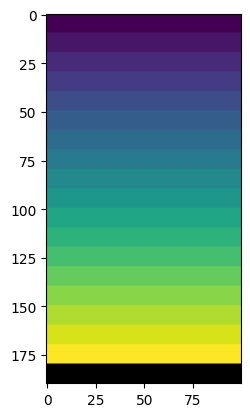

In [39]:
# https://discuss.pytorch.org/t/training-semantic-segmentation/49275/4
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch

# Create dummy target image
nb_classes = 19 - 1 # 18 classes + background
idx = np.linspace(0., 1., nb_classes)
cmap = matplotlib.colormaps['viridis']
rgb = cmap(idx, bytes=True)[:, :3]  # Remove alpha value

h, w = 190, 100
rgb = rgb.repeat(1000, 0)
target = np.zeros((h*w, 3), dtype=np.uint8)
target[:rgb.shape[0]] = rgb
target = target.reshape(h, w, 3)

plt.imshow(target) # Each class in 10 rows

# Create mapping
# Get color codes for dataset (maybe you would have to use more than a single
# image, if it doesn't contain all classes)
target = torch.from_numpy(target)
colors = torch.unique(target.view(-1, target.size(2)), dim=0).numpy()
target = target.permute(2, 0, 1).contiguous()
# print(colors)   
mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}

mask = torch.empty(h, w, dtype=torch.long)
print(mask)
for k in mapping:
    # Get all indices for current class
    idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
    validx = (idx.sum(0) == 3)  # Check that all channels match
    mask[validx] = torch.tensor(mapping[k], dtype=torch.long)
print(mask)
